## 2020-5-22  PyTorch 学习笔记（1）：多层全连接网络实现MNIST手写数字分类

In [1]:
## 导入有关的包
import torch
import torchvision.datasets as dset
from torch import nn,optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

## 下载实验需要数据集
root = ''
train_set = dset.MNIST('root', train=True, download=True) # train为true表示读取训练集，false表示读取测试集，
test_set = dset.MNIST('root', train=False, download=True) # download为True表示下载，为false表示从本地读取


In [2]:
## 描述并查看数据集
print("train_data:", train_set.train_data.size())
print("train_labels:", train_set.train_labels.size())
print("test_data:", test_set.test_data.size())

print("train_data:", train_set.train_data[2])
print("train_labels:", train_set.train_labels[2])


train_data: torch.Size([60000, 28, 28])
train_labels: torch.Size([60000])
test_data: torch.Size([10000, 28, 28])
train_data: tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
 

C:\Users\28038\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\28038\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\28038\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [3]:
##显示数据集
for i in range(5):
    image,label = train_set[i]
    path = 'C:\\Users\\28038\\NUDT-DL2020\\img\\{}-{}.png'.format(i,label)
    image.save(path)

## 实验部分1-数据部分

#### 将图片转化为可处理的tensor数据
在torchvision中提供了transforms用于帮我们对图片进行预处理和标准化。其中我们需要用到的有两个：ToTensor()和Normalize()。前者用于将图片转换成Tensor格式的数据，并且进行了标准化处理。后者用均值和标准偏差对张量图像进行归一化：给定均值: (M1,...,Mn) 和标准差: (S1,..,Sn) 用于 n 个通道, 该变换将标准化输入 torch.*Tensor 的每一个通道。其处理公式为:
而Compose函数可以将上述两个操作合并到一起执行。

In [4]:
## 先定义图片数据转换样式
# transforms.ToTensor()将图片转换成PyTorch中处理的对象Tensor,并且进行标准化（数据在0~1之间）
# transforms.Normalize()做归一化。它进行了减均值，再除以标准差。两个参数分别是均值和标准差
# transforms.Compose()函数则是将各种预处理的操作组合到了一起
data_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])])
#需要传入两个参数，一个是均值，一个是方差。减均值，除方

In [5]:
## 读取下载好的数据集，并进行数据转换处理。转换成所需要的tensor
train_dataset = dset.MNIST('root', train=True, transform=data_tf,download=False)
test_dataset = dset.MNIST('root', train=False, transform=data_tf, download=False) # 按data_tf的方式转化数据

#### torch.util.data的dataloader类：数据加载器https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True) # 数据加载器。组合了一个数据集和采样器，并提供关于数据的迭代器
test_loader = DataLoader(dataset=test_dataset, batch_size=64)
# 将原数据集做一个shuffle并做批处理，每个mini-batch的数目为64个，共有938个mini-batch,总数据量除以batch_size就是有多少个batch(一批数据)

# 数据加载的部分和上面取用一种就可以，不过后者应用了一些转换
print("train_data:", train_dataset.train_data.size())
print("train_labels:", train_dataset.train_labels.size())

print("train_data:", train_dataset.train_data[2][0].size())
print("train_labels:", train_dataset.train_labels[2])



train_data: torch.Size([60000, 28, 28])
train_labels: torch.Size([60000])
train_data: torch.Size([28])
train_labels: tensor(4)


## 实验部分2-构建计算图

- 1、利用类来完成定义网络层
- 2、选择激活函数 RELU
- 3、选择优化器 adam

In [6]:
import torch
import torch.nn.functional as F
import torch.nn as nn

## 定义一个三层的全连接网络
class FNModel(torch.nn.Module):#继承nn.module
    def __init__(self, in_dim, hidden1_dim, hidden2_dim,out_dim):
        super(FNModel,self).__init__()
        # torch.nn的线性层：https://pytorch.org/docs/stable/nn.html#linear-layers（输入的size,输出的size）
        
        self.l1 = nn.Linear(in_dim, hidden1_dim) #Linear中的w，b一定要初始化，若自己不定义初始化，则用默认的初始化方式初始化
        self.l2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.l3 = nn.Linear(hidden2_dim, out_dim)
        
        self.relu = nn.ReLU()#非线性层，激活函数既可以使用nn，又可以调用nn.functional
        
## 定义forward pass
    def forward(self,x):
        out = self.relu(self.l1(x)) # # 激活函数，直接调用torch.nn.functional中集成好的Relu
        out= self.relu(self.l2(out))
        out = self.relu(self.l3(out))
        return out

fnModel = FNModel(28 * 28, 300, 100, 10)     #输入图片是28x28，三层分别为300，100，100最后10类


## 实验部分3-选择损失函数与优化器

In [1]:
loss_fn=nn.CrossEntropyLoss()
#涉及到图像处理，故此处选择CrossEntropy损失函数
learning_rate=1e-2
optimizer = optim.Adam(fnModel.parameters(),lr=learning_rate)# 用了relu，所以lr很小
##注意报错，用fnModel,否则FNModel会因为没有实例化类而报错缺少位置参数self

NameError: name 'nn' is not defined

## 实验部分4-训练模型

In [8]:
#超参数配置
num_epochs=4

for epoch in range(num_epochs):
    batch=0
    for data in train_loader:
        img,label=data#img:torch.Size([64, 1, 28, 28])

        img=img.view(img.size(0),-1)#img:torch.Size([64, 784=28*28])


        img=torch.autograd.variable(img)#img=Variable(img)
        label=torch.autograd.variable(label)#包装一个Tensor,并记录用在它身上的operations :https://blog.csdn.net/KGzhang/article/details/77483383

    #开始训练
        
        out=fnModel(img)
    #计算loss
        loss=loss_fn(out,label)   
    #进行反向传导，之前要进行梯度归零
        optimizer.zero_grad()
        loss.backward()
    #进行优化
        optimizer.step()

    #再来一个epoch,并输出本epoch的结果
        batch+=1
        if batch%100== 0:
             print("epoch: {}, batch is 第{}, loss is {}".format(epoch, batch,loss))
        
        

C:\Users\28038\anaconda3\lib\site-packages\torch\autograd\__init__.py:179: UserWarning: torch.autograd.variable(...) is deprecated, use torch.tensor(...) instead
  warnings.warn("torch.autograd.variable(...) is deprecated, use torch.tensor(...) instead")
C:\Users\28038\anaconda3\lib\site-packages\torch\autograd\__init__.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(*args, **kwargs)


epoch: 0, batch is 第100, loss is 2.3025834560394287
epoch: 0, batch is 第200, loss is 2.3025834560394287
epoch: 0, batch is 第300, loss is 2.3025834560394287
epoch: 0, batch is 第400, loss is 2.3025834560394287
epoch: 0, batch is 第500, loss is 2.3025834560394287
epoch: 0, batch is 第600, loss is 2.3025834560394287
epoch: 0, batch is 第700, loss is 2.3025834560394287
epoch: 0, batch is 第800, loss is 2.3025834560394287
epoch: 0, batch is 第900, loss is 2.3025834560394287
epoch: 1, batch is 第100, loss is 2.3025834560394287
epoch: 1, batch is 第200, loss is 2.3025834560394287
epoch: 1, batch is 第300, loss is 2.3025834560394287
epoch: 1, batch is 第400, loss is 2.3025834560394287
epoch: 1, batch is 第500, loss is 2.3025834560394287
epoch: 1, batch is 第600, loss is 2.3025834560394287
epoch: 1, batch is 第700, loss is 2.3025834560394287
epoch: 1, batch is 第800, loss is 2.3025834560394287
epoch: 1, batch is 第900, loss is 2.3025834560394287
epoch: 2, batch is 第100, loss is 2.3025834560394287
epoch: 2, ba

## 实验部分-5 测试模型

In [9]:
# 测试评估
fnModel.eval()#模型测试
eval_loss = 0
eval_acc = 0
for data in test_loader:
    
    img, label = data#img:torch.Size([64, 1, 28, 28])
    img = img.view(img.size(0), -1)#img:torch.Size([64, 784=28*28])
    #label = label.view(label.size(0), -1) 不需要，因为label就是一维tensor
    
    out = fnModel(img)#一个batch_size的预测，每一个对应10类不一样概率
    #print(out.size())#一个batch_size的预测，每一个对应10类不一样概率
    loss = loss_fn(out, label)
    
    eval_loss += loss.data.item()*label.size(0)#扩大了64倍
    _, pred = torch.max(out, 1)#找到最大概率对应的索引号，该图片即为该索引号对应的类别
    num_correct = (pred == label).sum()
    eval_acc += num_correct.item()
    
    print('loss:{:.5f},   Test Loss: {:.5f}, Acc: {:.5f}'.format(#{:.5f}保留小数点几位
   loss, eval_loss / (len(test_dataset)),
    eval_acc / (len(test_dataset))
))

loss:2.30258,   Test Loss: 0.01474, Acc: 0.00070
loss:2.30258,   Test Loss: 0.02947, Acc: 0.00170
loss:2.30258,   Test Loss: 0.04421, Acc: 0.00200
loss:2.30258,   Test Loss: 0.05895, Acc: 0.00280
loss:2.30258,   Test Loss: 0.07368, Acc: 0.00350
loss:2.30258,   Test Loss: 0.08842, Acc: 0.00390
loss:2.30258,   Test Loss: 0.10316, Acc: 0.00460
loss:2.30258,   Test Loss: 0.11789, Acc: 0.00550
loss:2.30258,   Test Loss: 0.13263, Acc: 0.00610
loss:2.30258,   Test Loss: 0.14737, Acc: 0.00690
loss:2.30258,   Test Loss: 0.16210, Acc: 0.00740
loss:2.30258,   Test Loss: 0.17684, Acc: 0.00780
loss:2.30258,   Test Loss: 0.19157, Acc: 0.00810
loss:2.30258,   Test Loss: 0.20631, Acc: 0.00860
loss:2.30258,   Test Loss: 0.22105, Acc: 0.00900
loss:2.30258,   Test Loss: 0.23578, Acc: 0.00970
loss:2.30258,   Test Loss: 0.25052, Acc: 0.01030
loss:2.30258,   Test Loss: 0.26526, Acc: 0.01090
loss:2.30258,   Test Loss: 0.27999, Acc: 0.01130
loss:2.30258,   Test Loss: 0.29473, Acc: 0.01190
loss:2.30258,   Test

## 实验部分-6 保存模型及配置、加载模型

In [10]:
torch.save(fnModel, 'fnModel.pkl')  # 保存整个神经网络的结构和模型参数    
torch.save(fnModel.state_dict(), 'fnModel.parm.pkl') # 只保存神经网络的模型参数    

C:\Users\28038\anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type FNModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [11]:
# 加载整个模型(加载完整模型)   
FNModel = torch.load('./fnModel.pkl') 


## 实验部分-7 用加载的模型预测新图

[  0   0   0   0   0   0  16 231 252 253 252 252 252 226 227 252 231   0
   0   0   0   0   0   0   0   0   0   0]
(28, 28)
uint8


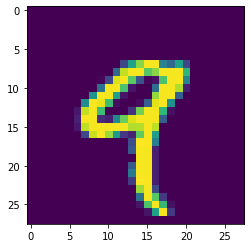

In [19]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
img1 = Image.open('4-9.png')#路径要用""
img1 = np.array(img1)#转化成数组
print(img1[15])#查看某一色彩通道
print(img1.shape)
print(img1.dtype)
plt.imshow(img1)#imshow()接收一张图像，只是画出该图，并不会立刻显示出来。imshow后还可以进行其他draw操作，比如scatter散点等。
plt.show()#画完后使用plt.show()才能进行结果的显示。

torch.Size([1, 28, 28])
torch.Size([1, 784])
torch.Size([1, 10])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<ReluBackward0>)



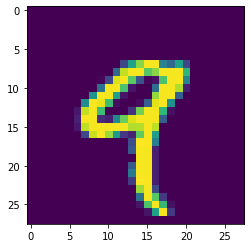

本图片是：9


In [21]:
input=data_tf(img1)#转换成符合输入的tensor
print(input.size())
input=input.view(input.size(0),-1)
print(input.size())
# img = img.unsqueeze(0)#增加一维batch_size，输出的img格式为[1,1,28,28]

score = FNModel(input)#将图片输入网络得到输出
print(score.size())
print(score)
max_value,index = torch.max(score, 1)#找到最大概率对应的索引号，该图片即为该索引号对应的类别
 #proba = F.relu(score)#计算该图片属于各类的概率,在网络层已经通过激活函数，因此本步不需要
 #max_value,index = torch.max(proba,1)
 #print(proba.size())
 #print(proba)
print()
plt.imshow(img1)#imshow()接收一张图像，只是画出该图，并不会立刻显示出来。imshow后还可以进行其他draw操作，比如scatter散点等。
plt.show()#画完后使用plt.show()才能进行结果的显示。
print("本图片是：{}".format(index.item()))


## debug记录-1



1、**TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>**


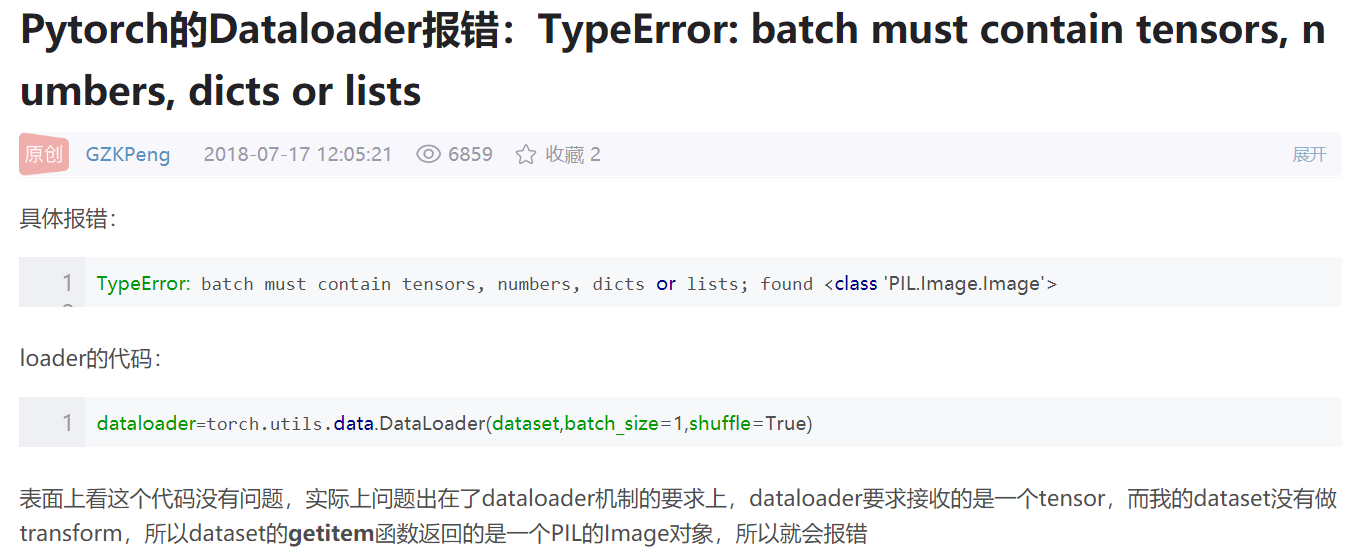

## debug记录-2  

- 了解dataset的读取机制

In [14]:
for data in test_loader:
    img, label = data
    #print(len(data)) data 是个list,第一项是img,第二项是label
    #print(len(data[0]))读取数据时已经设定了每个batch_size，所以是64个数据
    print("第一项是维度{}，第二项的维度{}".format(data[0].size(),data[1].size()))
    print("--------")
    print(data[0])#img被转换成tensor
    print(data[0].shape)
    print("--------")
    print(img.size())
    print(label.size(0))#64
    img = img.view(img.size(0), -1)
    print("--------")
    print(img.size())
    break

第一项是维度torch.Size([64, 1, 28, 28])，第二项的维度torch.Size([64])
--------
tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


### torch.max()的用法

_,b=torch.max(input,dim)代表，_存input的最大值，b存对应的索引值，dim0代表列，1代表行

In [15]:
import torch 
 
a=torch.randn(3)
print("a:\n",a)
print('max(a):',torch.max(a))
 


a:
 tensor([-0.3787,  0.3073,  0.5992])
max(a): tensor(0.5992)


In [16]:
b=torch.randn(3,4)
print("b:\n",b)
_,p=torch.max(b,0)#
print(_)
p
#print('max(b,0):',torch.max(b,0))
#print('max(b,1):',torch.max(b,1))

b:
 tensor([[-0.1768,  1.0225, -0.6572,  0.3356],
        [-0.7773,  1.6541,  0.8477, -0.6806],
        [ 0.6473,  1.4573,  0.4640, -0.3036]])
tensor([0.6473, 1.6541, 0.8477, 0.3356])


tensor([2, 1, 1, 0])

## 规范代码示例

In [17]:
import torch
from torch import optim, nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np

# 加载数据集
def get_data():
    # 定义数据预处理操作, transforms.Compose将各种预处理操作组合在一起
    data_tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
    train_dataset = datasets.MNIST(root='./data', train=True, transform=data_tf, download=True)
    test_dataset = datasets.MNIST(root='./data', train=False, transform=data_tf, download=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    #test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    return train_loader, test_dataset

# 构建模型，三层神经网络
class batch_net(nn.Module):
    def __init__(self, in_dim, hidden1_dim, hidden2_dim, out_dim):
        super(batch_net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, hidden1_dim), nn.BatchNorm1d(hidden1_dim), nn.ReLU(True))
        self.layer2 = nn.Sequential(nn.Linear(hidden1_dim, hidden2_dim), nn.BatchNorm1d(hidden2_dim), nn.ReLU(True))
        self.layer3 = nn.Sequential(nn.Linear(hidden2_dim, out_dim))
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x



if __name__ == "__main__":
    # 超参数配置
    batch_size = 64
    learning_rate = 1e-2
    num_epoches = 5
    # 加载数据集
    train_dataset, test_dataset = get_data()
    # 导入网络，并定义损失函数和优化器
    model = batch_net(28*28, 300, 100, 10)
    if torch.cuda.is_available():
        model = model.cuda()
    criterion = nn.CrossEntropyLoss()
    opitimizer = optim.SGD(model.parameters(), lr=learning_rate)
    # 开始训练
    for i in range(num_epoches):
        for img, label in train_dataset:
            img = img.view(64, -1)
            img = Variable(img)
            #print(img.size())
            label = Variable(label)
            # forward
            out = model(img)
            loss = criterion(out, label)
            # backward
            opitimizer.zero_grad()
            loss.backward()
            opitimizer.step()
            # 打印
            print("epoches= {},loss is {}".format(i, loss))
    # 测试
    model.eval()
    count = 0
    for data in test_dataset:
        img, label = data
        img = img.view(img.size(0), -1)
        img = Variable(img, volatile=True)
        #label = Variable(label, volatile=True)
        out = model(img)
        _, predict = torch.max(out, 1)
        if predict == label:
            count += 1
    print("acc = {}".format(count/len(test_dataset)))

RuntimeError: Expected object of device type cuda but got device type cpu for argument #2 'mat1' in call to _th_addmm